## The New York Times Covid-19 Database

The New York Times Covid-19 Database is 
a county-level database of confirmed cases and deaths, 
compiled from state and local governments and health departments across the United States.
The initial release of the database was on Thursday, March 26, 2020, and it is updated daily. 

These data have fueled many articles and graphics by The Times; these are updated regularly at
[https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html). 
The Times has created many visualizations that are effective communications of important information about the pandemic. 

The data are publically available via GitHub: [https://github.com/nytimes/covid-19-data](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html).  In this illustration we will only use
the data aggregated at the state level. 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
covid_table = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
covid_table = covid_table.drop('fips', axis=1)
covid_table.tail(20)

,date,state,cases,deaths
30464,2021-09-07,North Dakota,119995,1596
30465,2021-09-07,Northern Mariana Islands,248,2
30466,2021-09-07,Ohio,1262018,21020
30467,2021-09-07,Oklahoma,570923,8001
30468,2021-09-07,Oregon,289649,3335
30469,2021-09-07,Pennsylvania,1324720,28408
30470,2021-09-07,Puerto Rico,208063,2928
30471,2021-09-07,Rhode Island,164648,2778
30472,2021-09-07,South Carolina,773185,10972
30473,2021-09-07,South Dakota,134308,2074


### Process the recent data

Here is some code that creates a Table with the recent Covid-19 statistics for a given state. Just pass in the name of the state as a string.


In [3]:
merged_data = covid_table.drop('state', axis=1)
merged_data = merged_data.groupby('date').sum()
merged_data.tail(20)

,cases,deaths
date,,
2021-08-19,37458037,626099
2021-08-20,37657643,627631
2021-08-21,37737034,628100
2021-08-22,37777607,628285
2021-08-23,38043754,629644
2021-08-24,38193951,631057
2021-08-25,38364887,632522
2021-08-26,38552648,634735
2021-08-27,38748559,636509


In [4]:
new_cases = np.diff(merged_data['cases'])

# compute 7-day average
avg_cases = np.zeros(7)
for i in np.arange(7, len(new_cases)):
    avg_cases = np.append(avg_cases, np.mean(new_cases[(i-6):i+1]))

dates = np.array(merged_data['cases'].index)[1:]
data = np.array([new_cases, avg_cases]).T
cvd19 = pd.DataFrame(data, columns = ['new cases', '7-day avg'], index=dates)
cvd19.tail(10)

,new cases,7-day avg
2021-08-29,42158.0,156909.857143
2021-08-30,280403.0,158946.428571
2021-08-31,160250.0,160382.571429
2021-09-01,210995.0,166105.285714
2021-09-02,175696.0,164381.714286
2021-09-03,191475.0,163748.000000
2021-09-04,66054.0,161004.428571
2021-09-05,44417.0,161327.142857
2021-09-06,76976.0,132266.142857
2021-09-07,301138.0,152393.000000


In [5]:
cvd19.describe()

,new cases,7-day avg
count,595.000000,595.000000
mean,67871.225210,67120.637215
std,66211.655464,62270.237233
min,-23999.000000,0.000000
25%,23391.500000,23006.357143
50%,47335.000000,49335.142857
75%,78336.000000,78180.785714
max,301138.000000,259616.142857


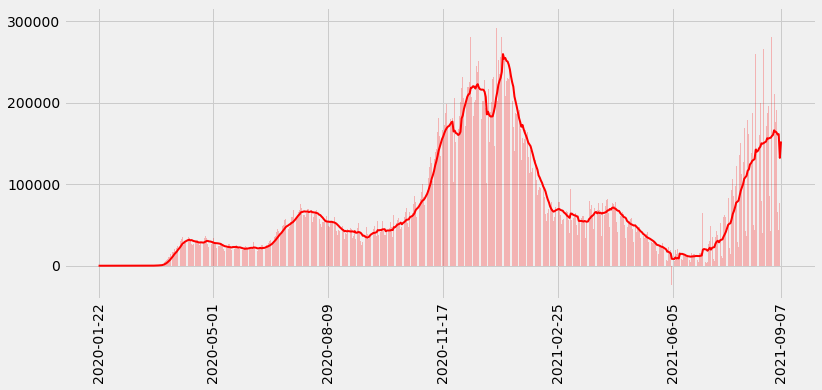

In [6]:
plt.figure(figsize=(12,5))
plt.bar(cvd19.index, cvd19['new cases'], color='red', alpha=.25)
plt.plot(cvd19.index, cvd19['7-day avg'], color='red', linewidth=2)
plt.xlabel('')
_ = plt.xticks(cvd19.index[[0, 100, 200, 300, 400, 500, len(dates)-1]], rotation=90)
_ = plt.yticks(np.linspace(0, 300000, 4))

Compare this to the graph here: [https://github.com/nytimes/covid-19-data](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html).


Let's now fit a linear regression to the recent data. First we filter to take everything after June 15.


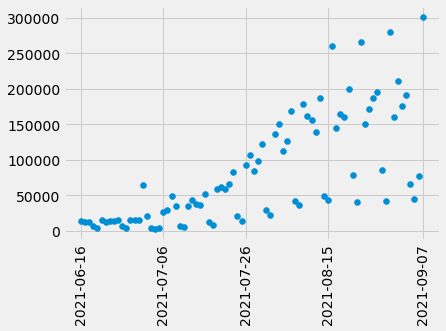

In [7]:
recent = cvd19[(cvd19.index > '2021-06-15') & (cvd19.index < '2021-09-09')]
y = recent['new cases']
dates = recent.index
plt.scatter(dates, y)
_ = plt.xticks(dates[[0, 20, 40, 60, len(dates)-1]], rotation=90)

Next we fit the "Ordinary Least Squares" regression using the `statsmodels.api` package.

In [8]:
import statsmodels.api as sm
x = np.arange(len(y))
X = sm.add_constant(x)
model = sm.OLS(y,X)
result = model.fit()
beta = [result.params.const, result.params.x1]

Finally, plot the results

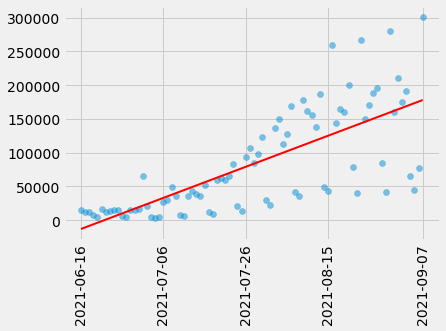

In [9]:
plt.scatter(dates, y, alpha=.5)
_ = plt.xticks(dates[[0, 20, 40, 60, len(dates)-1]], rotation=90)
_ = plt.plot(x, beta[0] + beta[1]*x, color='red', linewidth=2)

How would you describe the fit to the data? Can you filter out the low points (weekends?) and refit the model?